In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import xarray as xr
import xesmf as xe

import jaxparrow as jpw
from jaxparrow.utils import geometry, kinematics, operators


jax.config.update("jax_enable_x64", True)

Instead of considering idealized scenarios, we can use model data as validation material.
To make the demonstration closer to real data, we will generate pseudo-SWOT swath observations from the submesoscale-permitting eNATL60 simulation.

In [3]:
def get_karin_mask(swot_ds):
    return (np.abs(swot_ds.cross_track_distance) <= 60.0) & (np.abs(swot_ds.cross_track_distance) >= 10.0)


def get_regridder(enatl60_ds, swot_ds):
    regridder = xe.Regridder(enatl60_ds, swot_ds, "bilinear")
    return regridder


def regrid_enatl60_variable(enatl60_mb_da, regridder):
    regridded_da = regridder(enatl60_mb_da)
    return regridded_da


def arr_to_da(arr, lat, lon, name, units=None):
    attrs = {"long_name": name}
    if units is not None:
        attrs["units"] = units

    return xr.DataArray(
        arr,
        dims=("y", "x"),
        coords={"lat": (("y", "x"), lat.values), "lon": (("y", "x"), lon.values)},
        attrs=attrs
    )

In [4]:
ENATL60_PATH = "data/eNATL60"
SWOT_PATH = "data/SWOT"

## Produce pseudo-SWOT SSH data from eNATL60

This is done by regridding eNATL60 data onto the SWOT KaRin-swath grid.
Notes:

- use of several masks to avoid regridding over land or outside of SWOT bounding box,
- linear and nearest-neighbor reinterpolation of eNATL60 latitude and longitude whose values are (0, 0) to avoid potential regridding artifacts,
- separate regridding for the T, U, and V grids.

In [5]:
swot_003_ds = xr.open_dataset(f"{SWOT_PATH}/SWOT_L3_LR_SSH_Expert_003_v2.0.1-med.nc")
karin_003_mask = get_karin_mask(swot_003_ds)
swot_016_ds = xr.open_dataset(f"{SWOT_PATH}/SWOT_L3_LR_SSH_Expert_016_v2.0.1-med.nc")
karin_016_mask = get_karin_mask(swot_016_ds)

enatl60_t_ds = xr.open_dataset(f"{ENATL60_PATH}/eNATL60-BLB002_y2009m08d15.1d_SSH-med.nc")
enatl60_u_ds = xr.open_dataset(f"{ENATL60_PATH}/eNATL60-BLB002_y2009m08d15.1d_SSU-med.nc")
enatl60_v_ds = xr.open_dataset(f"{ENATL60_PATH}/eNATL60-BLB002_y2009m08d15.1d_SSV-med.nc")

enatl60_lat_t = jnp.asarray(enatl60_t_ds.lat)
enatl60_lon_t = jnp.asarray(enatl60_t_ds.lon)
enatl60_lat_u, enatl60_lon_u, enatl60_lat_v, enatl60_lon_v = geometry.compute_uv_grids(enatl60_lat_t, enatl60_lon_t)

enatl60_t_ds["uv"] = (
    ("y", "x"),
    np.asarray(
        kinematics.magnitude(jnp.asarray(enatl60_u_ds.sozocrtx.values), jnp.asarray(enatl60_v_ds.somecrty.values))
    ),
    {"units": "m/s", "long_name": "surface current (eNATL60)"}
)
enatl60_t_ds["nrv"] = (
    ("y", "x"),
    np.asarray(
        kinematics.normalized_relative_vorticity(
            jnp.asarray(enatl60_u_ds.sozocrtx.values), jnp.asarray(enatl60_v_ds.somecrty.values),
            enatl60_lat_u, enatl60_lon_u, enatl60_lat_v, enatl60_lon_v
        )
    ),
    {"long_name": "normalized relative vorticity (eNATL60)"}
)


We consider the Balearic Sea on the 15 August 2009.

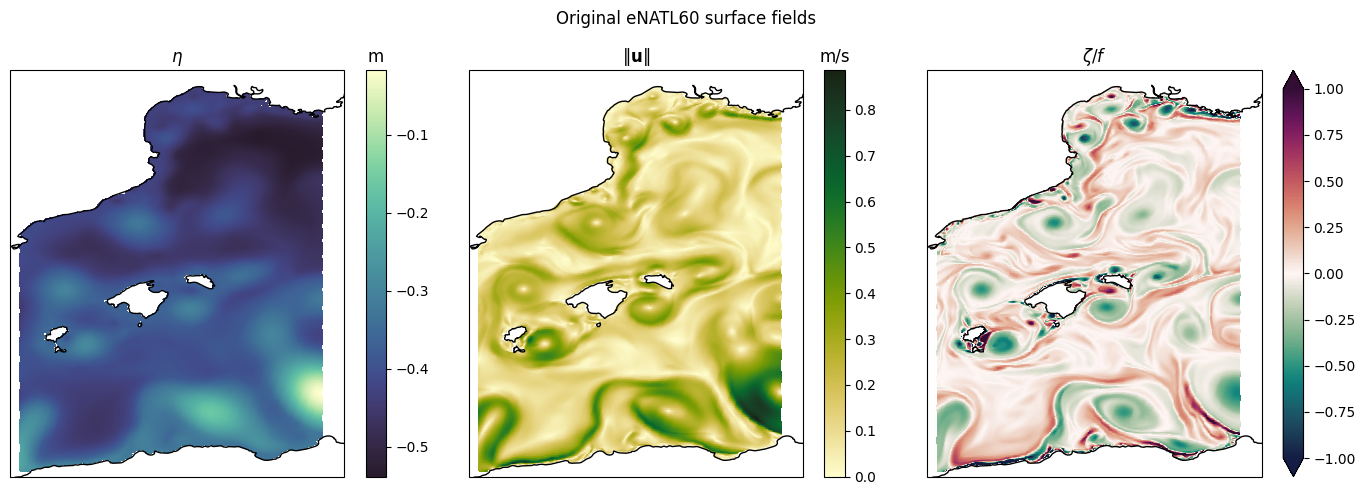

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(14, 5))

fig.suptitle("Original eNATL60 surface fields")

ax1.set_title("$\\eta$")
im = ax1.pcolormesh(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m")

ax2.set_title("$\|\\mathbf{u}\|$")
im = ax2.pcolormesh(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.uv, cmap=cmo.speed, vmin=0)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("$\\zeta / f$")
im = ax3.pcolormesh(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.nrv, cmap=cmo.curl, vmin=-1, vmax=1)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3, extend="both")

fig.tight_layout()
plt.show()

In [7]:
t_003_regridder = get_regridder(enatl60_t_ds, swot_003_ds)
u_003_regridder = get_regridder(enatl60_u_ds, swot_003_ds)
v_003_regridder = get_regridder(enatl60_v_ds, swot_003_ds)

t_016_regridder = get_regridder(enatl60_t_ds, swot_016_ds)
u_016_regridder = get_regridder(enatl60_u_ds, swot_016_ds)
v_016_regridder = get_regridder(enatl60_v_ds, swot_016_ds)

ssh_003_da = regrid_enatl60_variable(enatl60_t_ds.sossheig, t_003_regridder)
uv_003_da = regrid_enatl60_variable(enatl60_t_ds.uv, t_003_regridder)
nrv_003_da = regrid_enatl60_variable(enatl60_t_ds.nrv, t_003_regridder)
u_003_da = regrid_enatl60_variable(enatl60_u_ds.sozocrtx, u_003_regridder)
v_003_da = regrid_enatl60_variable(enatl60_v_ds.somecrty, v_003_regridder)

ssh_016_da = regrid_enatl60_variable(enatl60_t_ds.sossheig, t_016_regridder)
uv_016_da = regrid_enatl60_variable(enatl60_t_ds.uv, t_016_regridder)
nrv_016_da = regrid_enatl60_variable(enatl60_t_ds.nrv, t_016_regridder)
u_016_da = regrid_enatl60_variable(enatl60_u_ds.sozocrtx, u_016_regridder)
v_016_da = regrid_enatl60_variable(enatl60_v_ds.somecrty, v_016_regridder)

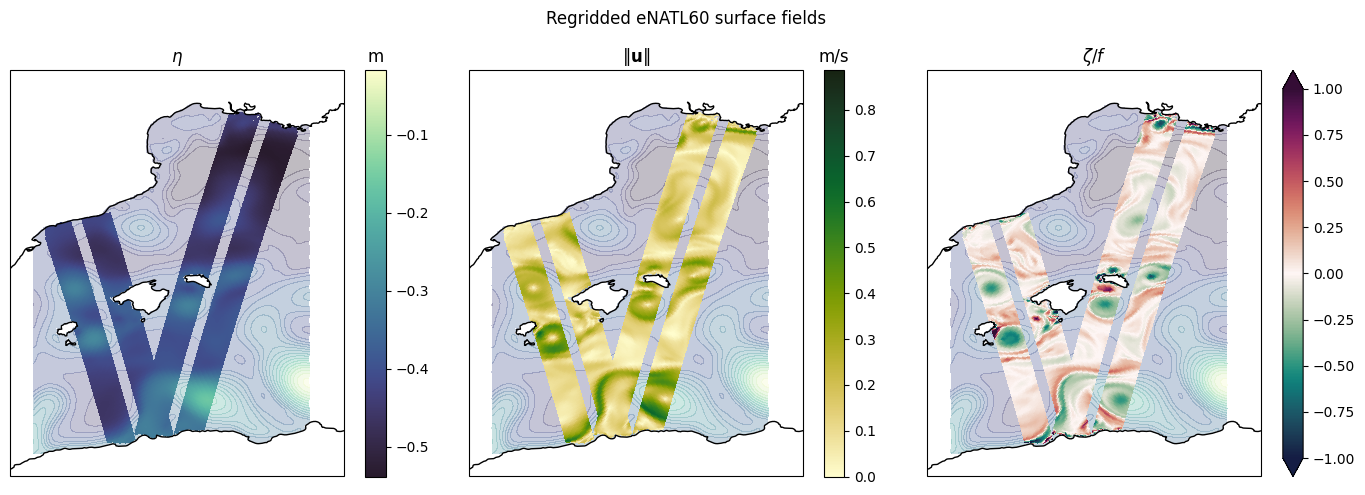

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(14, 5))

fig.suptitle("Regridded eNATL60 surface fields")

ssh_min = np.nanmin(enatl60_t_ds.sossheig)
ssh_max = np.nanmax(enatl60_t_ds.sossheig)
uv_max = np.nanmax(enatl60_t_ds.uv)

ax1.set_title("$\\eta$")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, ssh_003_da.where(karin_003_mask), 
    cmap=cmo.deep_r, vmin=ssh_min, vmax=ssh_max
)
im = ax1.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, ssh_016_da.where(karin_016_mask), 
    cmap=cmo.deep_r, vmin=ssh_min, vmax=ssh_max
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m")

ax2.set_title("$\|\\mathbf{u}\|$")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    uv_003_da.lon, uv_003_da.lat, uv_003_da.where(karin_003_mask), 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
im = ax2.pcolormesh(
    uv_016_da.lon, uv_016_da.lat, uv_016_da.where(karin_016_mask), 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("$\\zeta / f$")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    nrv_003_da.lon, nrv_003_da.lat, nrv_003_da.where(karin_003_mask), 
    cmap=cmo.curl, vmin=-1, vmax=1
)
im = ax3.pcolormesh(
    nrv_016_da.lon, nrv_016_da.lat, nrv_016_da.where(karin_016_mask), 
    cmap=cmo.curl, vmin=-1, vmax=1
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3, extend="both")

fig.tight_layout()
plt.show()

## Surface currents inversion of the pseudo-SWOT SSH data

We then apply the minimization-based and the fixed-point inversion methods to the pseudo-SWOT SSH data to estimate the cyclogeostrophic surface currents by calling the function [`cyclogeostrophy`](../api.md#jaxparrow.cyclogeostrophy.cyclogeostrophy).

For the minimization-based method, we minimize the cyclogeostrophic imbalance using gradient descent and clipping to avoid large updates.

From the estimated surface currents velocity $u$ and $v$ components, we compute the magnitude of the velocity and the normalized relative vorticity using [`magnitude`](../api.md#jaxparrow.utils.kinematics.magnitude) and [`normalized_relative_vorticity`](../api.md#jaxparrow.utils.kinematics.normalized_relative_vorticity).

In [9]:
optim = optax.chain(optax.clip(1), optax.sgd(learning_rate=5e-3))

swot_003_lat_t = jnp.asarray(swot_003_ds.lat)
swot_003_lon_t = jnp.asarray(swot_003_ds.lon)

# minimization-based
u_cg_mb_003, v_cg_mb_003, u_g_003, v_g_003, lat_u_003, lon_u_003, lat_v_003, lon_v_003 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_003_da.values), swot_003_lat_t, swot_003_lon_t, optim=optim, return_geos=True, return_grids=True
)
# fixed-point
u_cg_fp_003, v_cg_fp_003 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_003_da.values), swot_003_lat_t, swot_003_lon_t, 
    method="fixed-point", return_geos=False, return_grids=False
)

uv_g_003, uv_cg_mb_003, uv_cg_fp_003 = map(
    lambda args: kinematics.magnitude(*args), 
    ((u_g_003, v_g_003), (u_cg_mb_003, v_cg_mb_003), (u_cg_fp_003, v_cg_fp_003))
)
nrv_g_003, nrv_cg_mb_003, nrv_cg_fp_003 = map(
    lambda args: kinematics.normalized_relative_vorticity(*args, lat_u_003, lon_u_003, lat_v_003, lon_v_003), 
    ((u_g_003, v_g_003), (u_cg_mb_003, v_cg_mb_003), (u_cg_fp_003, v_cg_fp_003))
)

optim = optax.chain(optax.clip(1), optax.sgd(learning_rate=5e-3))

swot_016_lat_t = jnp.asarray(swot_016_ds.lat)
swot_016_lon_t = jnp.asarray(swot_016_ds.lon)

u_cg_mb_016, v_cg_mb_016, u_g_016, v_g_016, lat_u_016, lon_u_016, lat_v_016, lon_v_016 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_016_da.values), swot_016_lat_t, swot_016_lon_t, optim=optim, return_geos=True, return_grids=True
)
u_cg_fp_016, v_cg_fp_016 = jpw.cyclogeostrophy(
    jnp.asarray(ssh_016_da.values), swot_016_lat_t, swot_016_lon_t, 
    method="fixed-point", return_geos=False, return_grids=False
)

uv_g_016, uv_cg_mb_016, uv_cg_fp_016 = map(
    lambda args: kinematics.magnitude(*args), 
    ((u_g_016, v_g_016), (u_cg_mb_016, v_cg_mb_016), (u_cg_fp_016, v_cg_fp_016))
)
nrv_g_016, nrv_cg_mb_016, nrv_cg_fp_016 = map(
    lambda args: kinematics.normalized_relative_vorticity(*args, lat_u_016, lon_u_016, lat_v_016, lon_v_016), 
    ((u_g_016, v_g_016), (u_cg_mb_016, v_cg_mb_016), (u_cg_fp_016, v_cg_fp_016))
)

## Comparison with eNATL60

We have to interpolate SWOT $u$ and $v$ components onto the T grid, this can be achevied using the [`interpolation`](../api.md#jaxparrow.utils.operators.interpolation) function.

### Surface currents

In [10]:
u_g_003, u_cg_mb_003, u_cg_fp_003 = map(
    lambda arr: operators.interpolation(arr, mask=~jnp.isfinite(arr), axis=1, padding="left"), 
    (u_g_003, u_cg_mb_003, u_cg_fp_003)
)
v_g_003, v_cg_mb_003, v_cg_fp_003 = map(
    lambda arr: operators.interpolation(arr, mask=~jnp.isfinite(arr), axis=0, padding="left"), 
    (v_g_003, v_cg_mb_003, v_cg_fp_003)
)

u_g_016, u_cg_mb_016, u_cg_fp_016 = map(
    lambda arr: operators.interpolation(arr, mask=~jnp.isfinite(arr), axis=1, padding="left"), 
    (u_g_016, u_cg_mb_016, u_cg_fp_016)
)
v_g_016, v_cg_mb_016, v_cg_fp_016 = map(
    lambda arr: operators.interpolation(arr, mask=~jnp.isfinite(arr), axis=0, padding="left"), 
    (v_g_016, v_cg_mb_016, v_cg_fp_016)
)

In [11]:
(
    u_g_003, v_g_003, u_cg_mb_003, v_cg_mb_003, u_cg_fp_003, v_cg_fp_003, uv_g_003, uv_cg_mb_003, uv_cg_fp_003, 
    nrv_g_003, nrv_cg_mb_003, nrv_cg_fp_003
) = map(
    lambda arr: jnp.where(karin_003_mask.values.T, arr, jnp.nan), 
    (
        u_g_003, v_g_003, u_cg_mb_003, v_cg_mb_003, u_cg_fp_003, v_cg_fp_003, uv_g_003, uv_cg_mb_003, uv_cg_fp_003, 
        nrv_g_003, nrv_cg_mb_003, nrv_cg_fp_003
    )
)

(
    u_g_016, v_g_016, u_cg_mb_016, v_cg_mb_016, u_cg_fp_016, v_cg_fp_016, uv_g_016, uv_cg_mb_016, uv_cg_fp_016, 
    nrv_g_016, nrv_cg_mb_016, nrv_cg_fp_016
) = map(
    lambda arr: jnp.where(karin_016_mask.values.T, arr, jnp.nan), 
    (
        u_g_016, v_g_016, u_cg_mb_016, v_cg_mb_016, u_cg_fp_016, v_cg_fp_016, uv_g_016, uv_cg_mb_016, uv_cg_fp_016, 
        nrv_g_016, nrv_cg_mb_016, nrv_cg_fp_016
    )
)

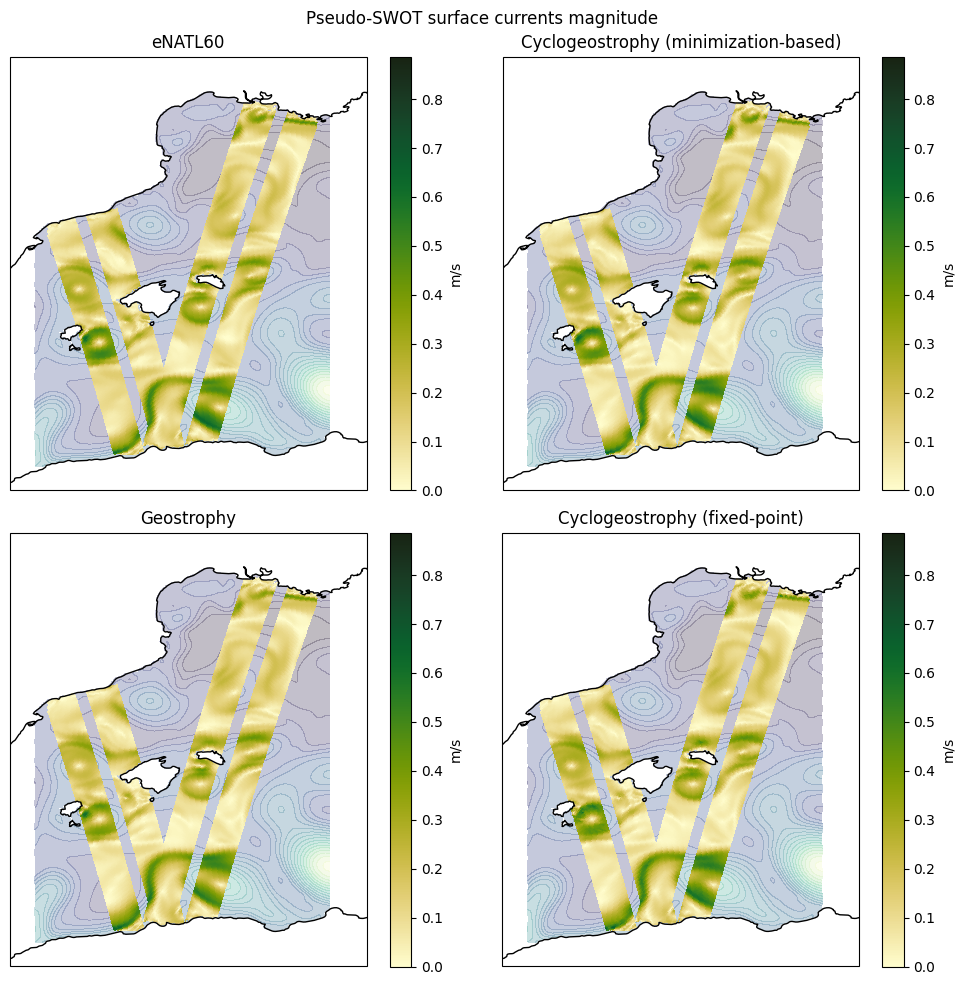

In [12]:
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.suptitle("Pseudo-SWOT surface currents magnitude")

ax1.set_title("eNATL60")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    uv_003_da.lon, uv_003_da.lat, uv_003_da.where(karin_003_mask), 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
im = ax1.pcolormesh(
    uv_016_da.lon, uv_016_da.lat, uv_016_da.where(karin_016_mask), 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("m/s")

ax2.set_title("Cyclogeostrophy (minimization-based)")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    uv_003_da.lon, uv_003_da.lat, uv_cg_mb_003, 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
im = ax2.pcolormesh(
    uv_016_da.lon, uv_016_da.lat, uv_cg_mb_016, 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("m/s")

ax3.set_title("Geostrophy")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    uv_003_da.lon, uv_003_da.lat, uv_g_003, 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
im = ax3.pcolormesh(
    uv_016_da.lon, uv_016_da.lat, uv_g_016, 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3)
cbar.set_label("m/s")

ax4.set_title("Cyclogeostrophy (fixed-point)")
_ = ax4.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax4.pcolormesh(
    uv_003_da.lon, uv_003_da.lat, uv_cg_fp_003, 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
im = ax4.pcolormesh(
    uv_016_da.lon, uv_016_da.lat, uv_cg_fp_016, 
    cmap=cmo.speed, vmin=0, vmax=uv_max
)
ax4.coastlines()
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label("m/s")

fig.tight_layout()
plt.show()

In [13]:
u_003_ref = jnp.asarray(u_003_da.values)
v_003_ref = jnp.asarray(v_003_da.values)

uv_err_g_003, uv_err_cg_mb_003, uv_err_cg_fp_003 = map(
    lambda u, v: kinematics.magnitude(u - u_003_ref, v - v_003_ref), 
    (u_g_003, u_cg_mb_003, u_cg_fp_003), (v_g_003, v_cg_mb_003, v_cg_fp_003)
)

u_016_ref = jnp.asarray(u_016_da.values)
v_016_ref = jnp.asarray(v_016_da.values)

uv_err_g_016, uv_err_cg_mb_016, uv_err_cg_fp_016 = map(
    lambda u, v: kinematics.magnitude(u - u_016_ref, v - v_016_ref), 
    (u_g_016, u_cg_mb_016, u_cg_fp_016), (v_g_016, v_cg_mb_016, v_cg_fp_016)
)

uv_err_max = max(
    jnp.nanmax(uv_err_g_003), jnp.nanmax(uv_err_g_016), 
    jnp.nanmax(uv_err_cg_mb_003), jnp.nanmax(uv_err_cg_mb_016), 
    jnp.nanmax(uv_err_cg_fp_003), jnp.nanmax(uv_err_cg_fp_016)
)

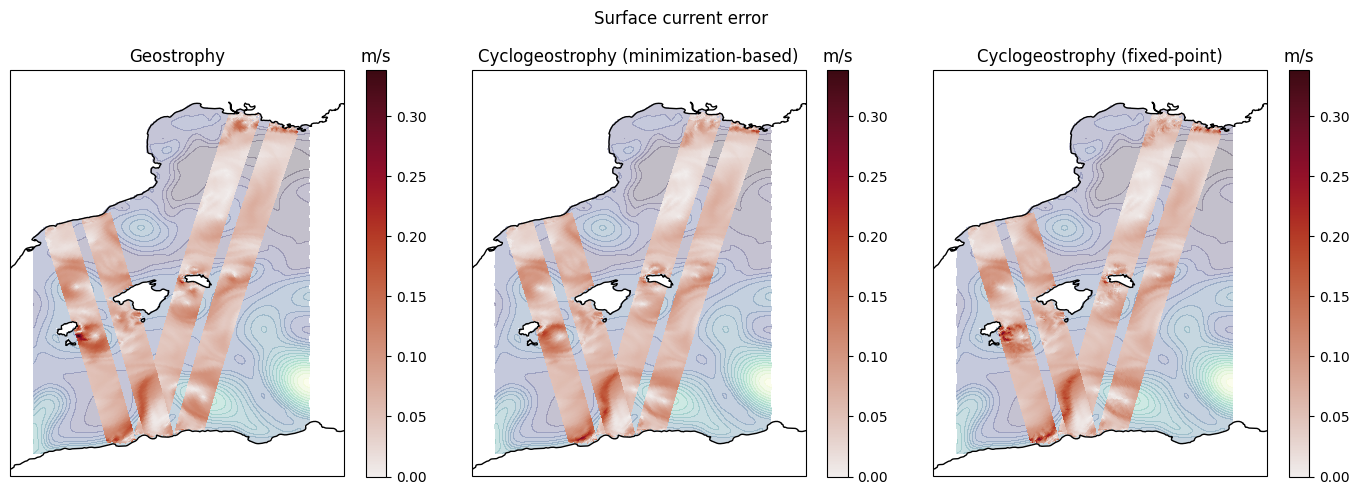

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(14, 5))

fig.suptitle("Surface current error")

ax1.set_title("Geostrophy")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, uv_err_g_003, 
    cmap=cmo.amp, vmin=0, vmax=uv_err_max
)
im = ax1.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, uv_err_g_016, 
    cmap=cmo.amp, vmin=0, vmax=uv_err_max
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")

ax2.set_title("Cyclogeostrophy (minimization-based)")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, uv_err_cg_mb_003, 
    cmap=cmo.amp, vmin=0, vmax=uv_err_max
)
im = ax2.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, uv_err_cg_mb_016, 
    cmap=cmo.amp, vmin=0, vmax=uv_err_max
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("Cyclogeostrophy (fixed-point)")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, uv_err_cg_fp_003, 
    cmap=cmo.amp, vmin=0, vmax=uv_err_max
)
im = ax3.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, uv_err_cg_fp_016, 
    cmap=cmo.amp, vmin=0, vmax=uv_err_max
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3)
cbar.ax.set_title("m/s")

fig.tight_layout()
plt.show()

In [15]:
uv_err_diff_geos_mb_003 = (uv_err_g_003 - uv_err_cg_mb_003)
uv_err_diff_geos_fp_003 = (uv_err_g_003 - uv_err_cg_fp_003)
uv_err_diff_fp_mb_003 = (uv_err_cg_fp_003 - uv_err_cg_mb_003)

uv_err_diff_geos_mb_016 = (uv_err_g_016 - uv_err_cg_mb_016)
uv_err_diff_geos_fp_016 = (uv_err_g_016 - uv_err_cg_fp_016)
uv_err_diff_fp_mb_016 = (uv_err_cg_fp_016 - uv_err_cg_mb_016)

uv_err_diff_max = max(
    np.nanmax(np.abs(uv_err_diff_geos_mb_003)),
    np.nanmax(np.abs(uv_err_diff_geos_fp_003)),
    np.nanmax(np.abs(uv_err_diff_fp_mb_003)),
    np.nanmax(np.abs(uv_err_diff_geos_mb_016)),
    np.nanmax(np.abs(uv_err_diff_geos_fp_016)),
    np.nanmax(np.abs(uv_err_diff_fp_mb_016))
)

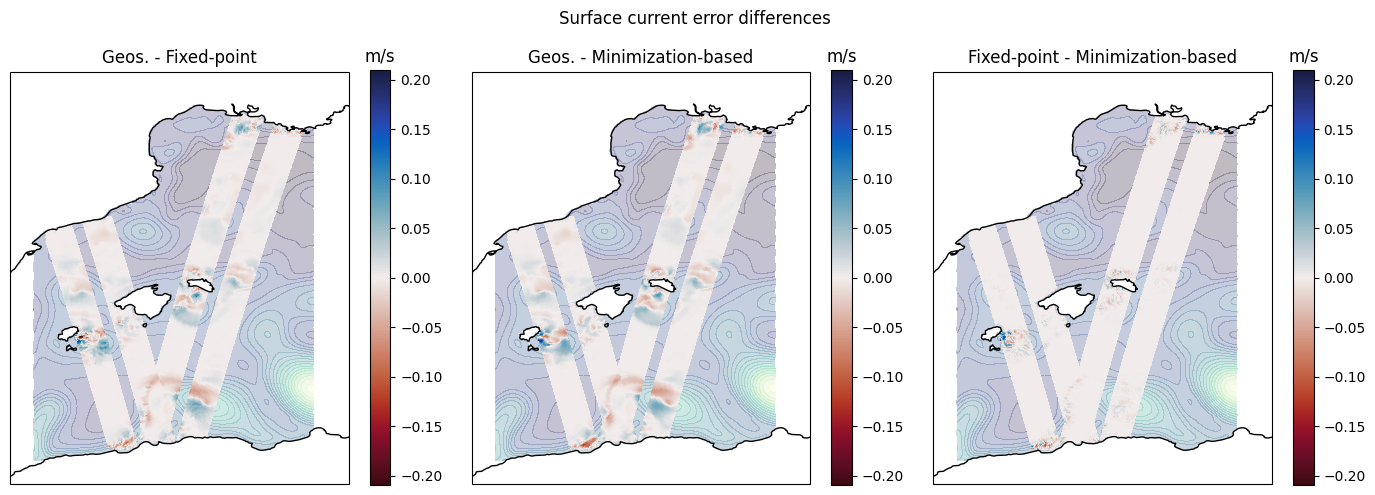

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(14, 5))

fig.suptitle("Surface current error differences")

ax1.set_title("Geos. - Fixed-point")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, uv_err_diff_geos_fp_003, 
    cmap=cmo.balance_r, vmin=-uv_err_diff_max, vmax=uv_err_diff_max
)
im = ax1.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, uv_err_diff_geos_fp_016, 
    cmap=cmo.balance_r, vmin=-uv_err_diff_max, vmax=uv_err_diff_max
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")

ax2.set_title("Geos. - Minimization-based")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, uv_err_diff_geos_mb_003, 
    cmap=cmo.balance_r, vmin=-uv_err_diff_max, vmax=uv_err_diff_max
)
im = ax2.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, uv_err_diff_geos_mb_016, 
    cmap=cmo.balance_r, vmin=-uv_err_diff_max, vmax=uv_err_diff_max
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("Fixed-point - Minimization-based")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, uv_err_diff_fp_mb_003, 
    cmap=cmo.balance_r, vmin=-uv_err_diff_max, vmax=uv_err_diff_max
)
im = ax3.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, uv_err_diff_fp_mb_016, 
    cmap=cmo.balance_r, vmin=-uv_err_diff_max, vmax=uv_err_diff_max
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3)
cbar.ax.set_title("m/s")

fig.tight_layout()
plt.show()

Both cyclogeostrophic inversion methods give similar results but it is already possible to notice that the minimization-based approach produce spatially smoother estimates.

### Normalized relative vorticity

The grainy aspect of the fixed-point estimate will be more visible in the normalized relative vorticity fields as it involves the computation of spatial derivatives.

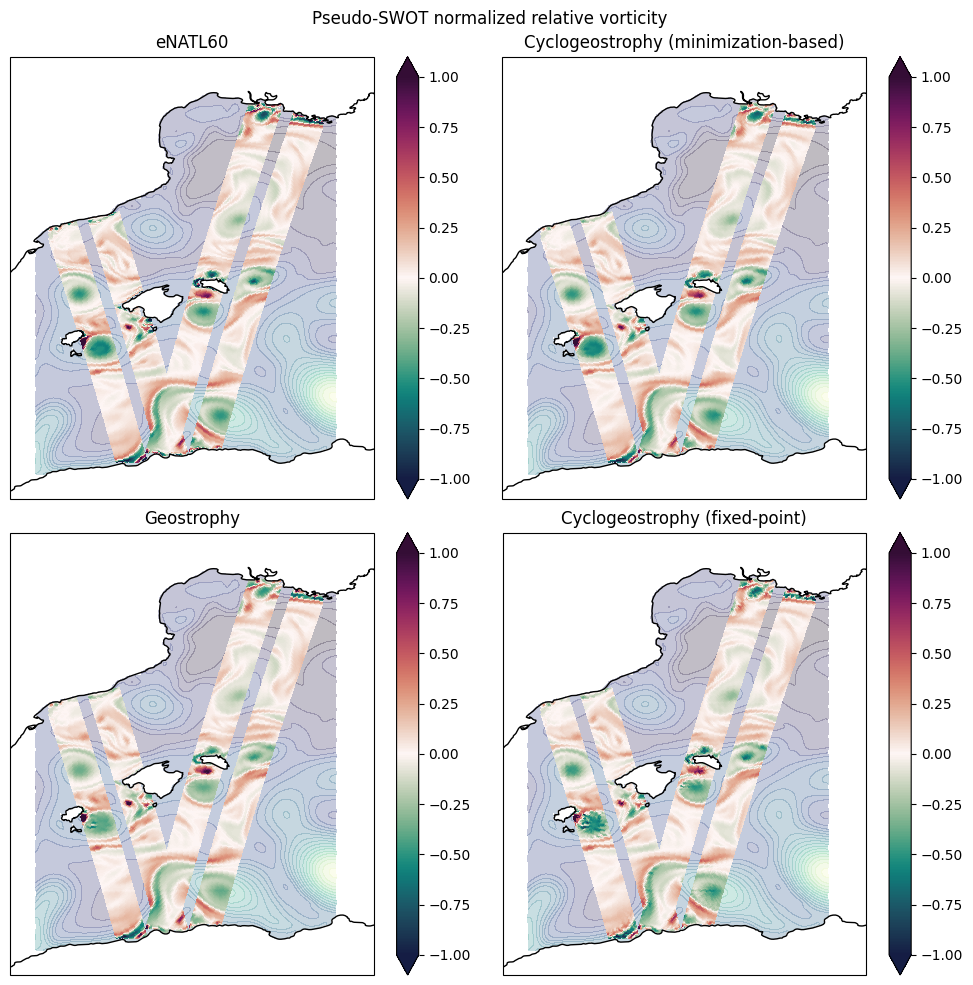

In [17]:
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.suptitle("Pseudo-SWOT normalized relative vorticity")

ax1.set_title("eNATL60")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    nrv_003_da.lon, nrv_003_da.lat, nrv_003_da.where(karin_003_mask), 
    cmap=cmo.curl, vmin=-1, vmax=1
)
im = ax1.pcolormesh(
    nrv_016_da.lon, nrv_016_da.lat, nrv_016_da.where(karin_016_mask), 
    cmap=cmo.curl, vmin=-1, vmax=1
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1, extend="both")

ax2.set_title("Cyclogeostrophy (minimization-based)")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    nrv_003_da.lon, nrv_003_da.lat, nrv_cg_mb_003, 
    cmap=cmo.curl, vmin=-1, vmax=1
)
im = ax2.pcolormesh(
    nrv_016_da.lon, nrv_016_da.lat, nrv_cg_mb_016, 
    cmap=cmo.curl, vmin=-1, vmax=1
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2, extend="both")

ax3.set_title("Geostrophy")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    nrv_003_da.lon, nrv_003_da.lat, nrv_g_003, 
    cmap=cmo.curl, vmin=-1, vmax=1
)
im = ax3.pcolormesh(
    nrv_016_da.lon, nrv_016_da.lat, nrv_g_016, 
    cmap=cmo.curl, vmin=-1, vmax=1
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3, extend="both")

ax4.set_title("Cyclogeostrophy (fixed-point)")
_ = ax4.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax4.pcolormesh(
    nrv_003_da.lon, nrv_003_da.lat, nrv_cg_fp_003, 
    cmap=cmo.curl, vmin=-1, vmax=1
)
im = ax4.pcolormesh(
    nrv_016_da.lon, nrv_016_da.lat, nrv_cg_fp_016, 
    cmap=cmo.curl, vmin=-1, vmax=1
)
ax4.coastlines()
cbar = plt.colorbar(im, ax=ax4, extend="both")

fig.tight_layout()
plt.show()

In [18]:
nrv_err_g_003, nrv_err_cg_mb_003, nrv_err_cg_fp_003 = map(
    lambda nrv_est: np.abs(nrv_003_da.values - nrv_est), 
    (nrv_g_003, nrv_cg_mb_003, nrv_cg_fp_003)
)

nrv_err_g_016, nrv_err_cg_mb_016, nrv_err_cg_fp_016 = map(
    lambda nrv_est: np.abs(nrv_016_da.values - nrv_est), 
    (nrv_g_016, nrv_cg_mb_016, nrv_cg_fp_016)
)

nrv_err_max = 0.25

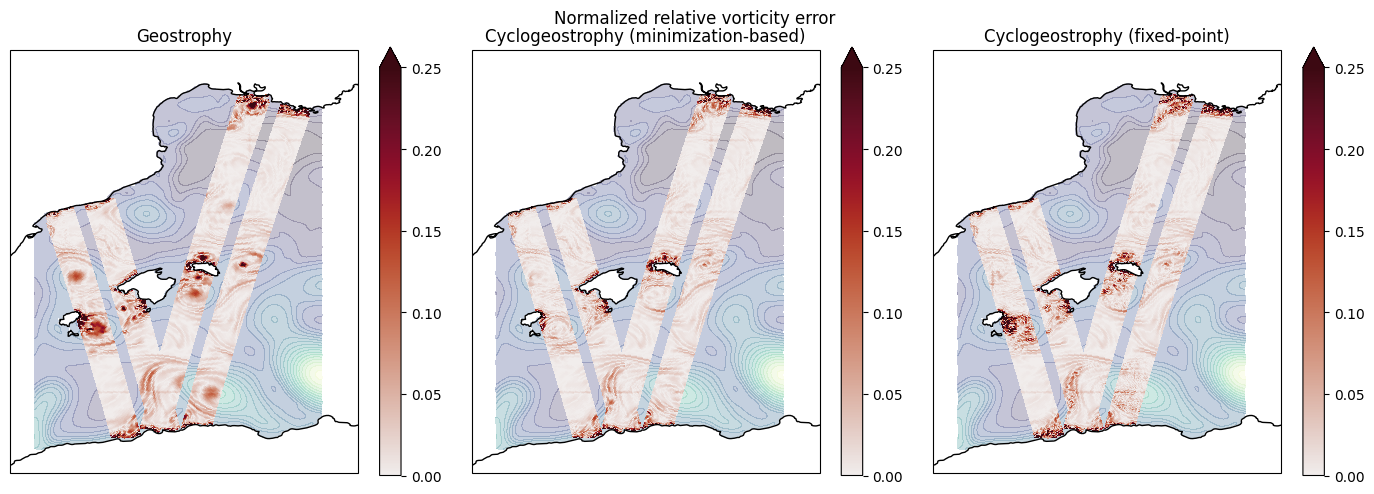

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(14, 5))

fig.suptitle("Normalized relative vorticity error")

ax1.set_title("Geostrophy")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, nrv_err_g_003, 
    cmap=cmo.amp, vmin=0, vmax=nrv_err_max
)
im = ax1.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, nrv_err_g_016, 
    cmap=cmo.amp, vmin=0, vmax=nrv_err_max
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1, extend="max")

ax2.set_title("Cyclogeostrophy (minimization-based)")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, nrv_err_cg_mb_003, 
    cmap=cmo.amp, vmin=0, vmax=nrv_err_max
)
im = ax2.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, nrv_err_cg_mb_016, 
    cmap=cmo.amp, vmin=0, vmax=nrv_err_max
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2, extend="max")

ax3.set_title("Cyclogeostrophy (fixed-point)")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, nrv_err_cg_fp_003, 
    cmap=cmo.amp, vmin=0, vmax=nrv_err_max
)
im = ax3.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, nrv_err_cg_fp_016, 
    cmap=cmo.amp, vmin=0, vmax=nrv_err_max
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3, extend="max")

fig.tight_layout()
plt.show()

In [20]:
nrv_err_diff_geos_mb_003 = (nrv_err_g_003 - nrv_err_cg_mb_003)
nrv_err_diff_geos_fp_003 = (nrv_err_g_003 - nrv_err_cg_fp_003)
nrv_err_diff_fp_mb_003 = (nrv_err_cg_fp_003 - nrv_err_cg_mb_003)

nrv_err_diff_geos_mb_016 = (nrv_err_g_016 - nrv_err_cg_mb_016)
nrv_err_diff_geos_fp_016 = (nrv_err_g_016 - nrv_err_cg_fp_016)
nrv_err_diff_fp_mb_016 = (nrv_err_cg_fp_016 - nrv_err_cg_mb_016)

nrv_err_diff_max = 0.25

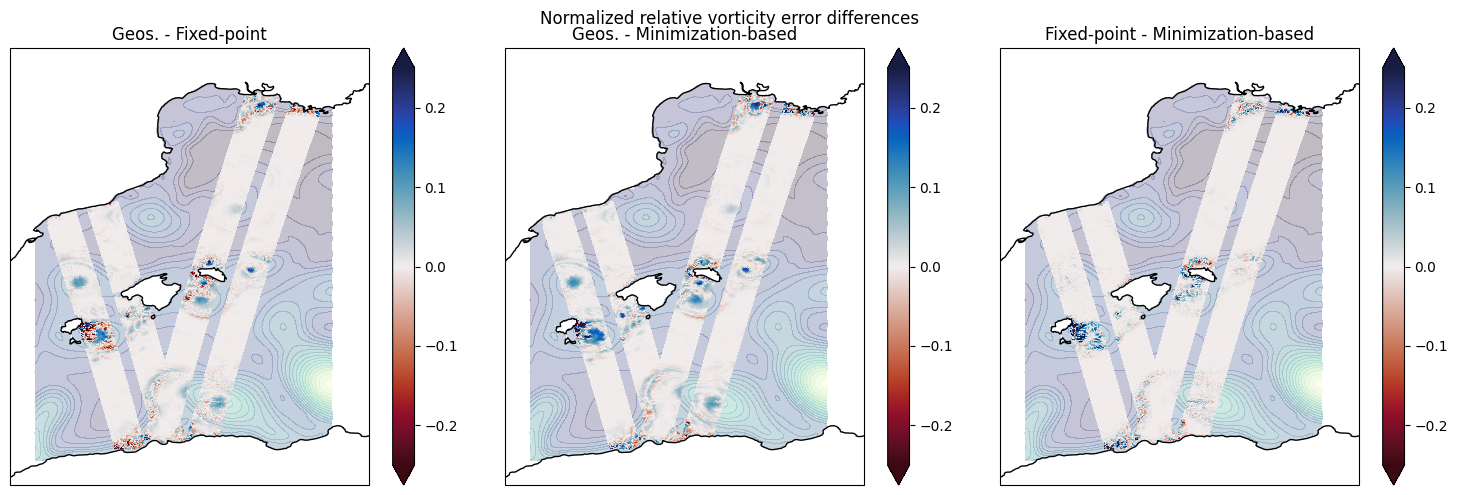

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(15, 5))

fig.suptitle("Normalized relative vorticity error differences")

ax1.set_title("Geos. - Fixed-point")
_ = ax1.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax1.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, nrv_err_diff_geos_fp_003, 
    cmap=cmo.balance_r, vmin=-nrv_err_diff_max, vmax=nrv_err_diff_max
)
im = ax1.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, nrv_err_diff_geos_fp_016, 
    cmap=cmo.balance_r, vmin=-nrv_err_diff_max, vmax=nrv_err_diff_max
)
ax1.coastlines()
cbar = plt.colorbar(im, ax=ax1, extend="both")

ax2.set_title("Geos. - Minimization-based")
_ = ax2.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax2.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, nrv_err_diff_geos_mb_003, 
    cmap=cmo.balance_r, vmin=-nrv_err_diff_max, vmax=nrv_err_diff_max
)
im = ax2.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, nrv_err_diff_geos_mb_016, 
    cmap=cmo.balance_r, vmin=-nrv_err_diff_max, vmax=nrv_err_diff_max
)
ax2.coastlines()
cbar = plt.colorbar(im, ax=ax2, extend="both")

ax3.set_title("Fixed-point - Minimization-based")
_ = ax3.contourf(enatl60_t_ds.lon, enatl60_t_ds.lat, enatl60_t_ds.sossheig, cmap=cmo.deep_r, levels=20, alpha=0.3)
_ = ax3.pcolormesh(
    ssh_003_da.lon, ssh_003_da.lat, nrv_err_diff_fp_mb_003, 
    cmap=cmo.balance_r, vmin=-nrv_err_diff_max, vmax=nrv_err_diff_max
)
im = ax3.pcolormesh(
    ssh_016_da.lon, ssh_016_da.lat, nrv_err_diff_fp_mb_016, 
    cmap=cmo.balance_r, vmin=-nrv_err_diff_max, vmax=nrv_err_diff_max
)
ax3.coastlines()
cbar = plt.colorbar(im, ax=ax3, extend="both")

fig.tight_layout()
plt.show()

As anticipated, the minimization-based approach produces spatially smoother estimates of the normalized relative vorticity.